## 2. Data Cleaning

#### Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import re
from bs4 import BeautifulSoup
from nltk import word_tokenize   
from nltk.tokenize import RegexpTokenizer
import emoji
import contractions

In [2]:
# Set plot theme 
plt.style.use('Solarize_Light2')

### Data Cleaning

- Concatenate
- Remove duplicates
- Remove Links
- Remove Numbers

Data Concatenation and Check & Drop Duplicates

In [3]:
# As we scraped more posts from askdocs, we would retain enough to make a balanced sample 
# between the two
df_suicidewatch = pd.read_csv('../Data/data_suicidewatch.csv')
df_mentalhealth = pd.read_csv('../Data/data_mentalhealth.csv')

Check for missing data

<AxesSubplot:>

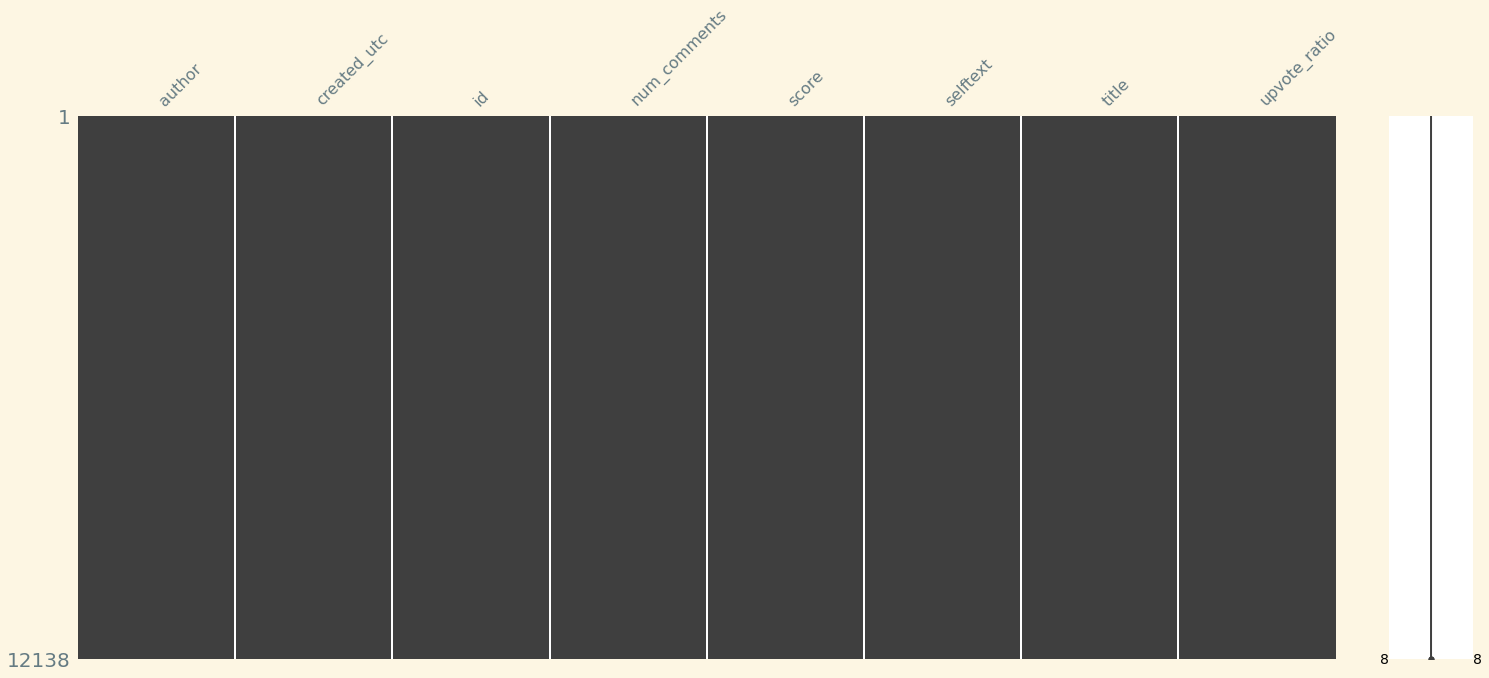

In [4]:
# plot missing data matrix for r/SuicideWatch
msno.matrix(df_suicidewatch)

No missing data in df_sucidewatch

<AxesSubplot:>

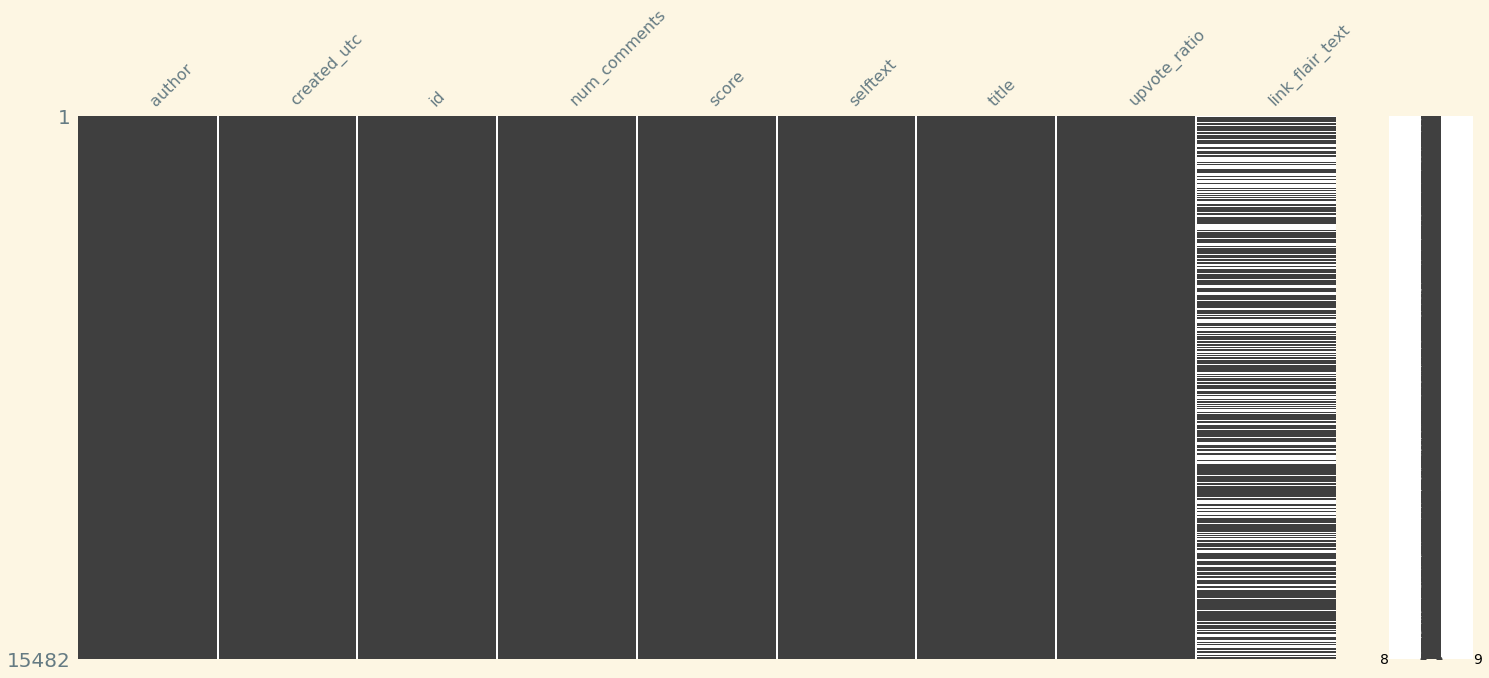

In [5]:
# plot missing data matrix for r/MentalHealth
msno.matrix(df_mentalhealth)

We find missing data in link_flair_text, we will look into this column in more detail in the following section.

#### Flair categories

The flair is a feature of Reddit where users can tag their own posts to indicate what category the post belongs to. A subreddit may enable this function in order to allow users to filter for categories that they are interested in. 

We find that there are a small number flairs that are poorly classified. And there are also a significant number of posts, about one-third, that are uncategorized as well. We would put the poorly classified and unclassified into a 'none' category.

As is a self-assessed categorization it may not be accurate, and given that there are many unclassified posts, we won't be using this for classification modelling, but may utilitize some of the categories in our analysis.

We would make some groupings in categories analysis and model evaluation later on, but we wont attempt do too much reclassification as number of categories that have few members 3 and below is insiginficant to the overall population. 

Main categories would keep their original names, and NaN and anything below 3 as "None". We would also classify categories into sentiments that are positive, neutral, and distressed. We leave "Questions" & "Opinion / Thoughts" as its own category as they are relatively large categories, and a cursory look at the subreddit indicate that these categories may contain distressed posts as well.

In [6]:
df_mentalhealth.shape

(15482, 9)

In [7]:
# Create DataFrame of count of cateories in link_flair_text
flair_count = pd.DataFrame(df_mentalhealth[['link_flair_text']].value_counts(dropna=False), 
                           columns=['count']).reset_index()
display(flair_count)

,link_flair_text,count
0,NaN,5444
1,Question,3049
2,Need Support,2565
3,Venting,2297
4,Opinion / Thoughts,1019
...,...,...
57,Question- PTSD,1
58,Question/Advice,1
59,Question/Confused,1
60,Question/Support Query,1


In [8]:
# cateories in link_flair_text that is more than 3
flair_count[flair_count['count']>3]

,link_flair_text,count
0,NaN,5444
1,Question,3049
2,Need Support,2565
3,Venting,2297
4,Opinion / Thoughts,1019
5,Sadness / Grief,483
6,Good News / Happy,194
7,Inspiration / Encouragement,193
8,Resources,107
9,Research Study,64


In [9]:
# cateories in link_flair_text that is 3 or less
flair_count[flair_count['count']<=3]

,link_flair_text,count
11,idk,3
12,Advice,3
13,anyone else,2
14,Question,2
15,How to deal with alcoholism and depression sim...,1
16,Vent/Need advice,1
17,Question/support,1
18,Question: How can I help my boyfriend?,1
19,Question: What am I experiencing that even doc...,1
20,Questionplzhelp,1


Mapping of categories

In [10]:
# Create list of small categories
small = flair_count[flair_count['count']<=3]['link_flair_text'].tolist()

In [11]:
# Create list of neutral categories
neutral = ['Resources', 'Research Study', 'Member Poll ']

In [12]:
# Create list of positive categories
positive = ['Good News / Happy', 'Inspiration / Encouragement']

In [13]:
distressed = ['Need Support', 'Venting', 'Sadness / Grief']

In [14]:
# Create list of categories that we use to apply an inverse mask to select large categories
cats = small + neutral + positive + distressed + ['None']

In [15]:
# Large categories would keep their original names
df_mentalhealth.loc[~df_mentalhealth['link_flair_text'].isin(cats),'flair_group'] = \
    df_mentalhealth['link_flair_text']

In [16]:
# Assign small categories as 'None'
df_mentalhealth.loc[df_mentalhealth['link_flair_text'].isin(small),'flair_group'] = 'None'

In [17]:
# Assign NaN as 'None'
df_mentalhealth.loc[df_mentalhealth['link_flair_text'].isna(),'link_flair_text'] = 'None'
df_mentalhealth.loc[df_mentalhealth['link_flair_text']=='None','flair_group'] = 'None'

In [18]:
# Assign neutral categories
df_mentalhealth.loc[df_mentalhealth['link_flair_text'].isin(neutral),'flair_group'] = 'Neutral'

In [19]:
# Assign positive categories 
df_mentalhealth.loc[df_mentalhealth['link_flair_text'].isin(positive),'flair_group'] = 'Positive'

In [20]:
# Assign distressed categories 
df_mentalhealth.loc[df_mentalhealth['link_flair_text'].isin(distressed),'flair_group'] = 'Distressed'

In [21]:
# Check new categories
df_mentalhealth[['flair_group']].value_counts(dropna=False)

flair_group       
None                  5501
Distressed            5345
Question              3049
Opinion / Thoughts    1019
Positive               387
Neutral                181
dtype: int64

Combine both dataframes together, and create a new column to indicate which subreddit the submission is from r/askdocs would be 0 and r/loseit would be 1

In [22]:
# Concatenate both DataFrames for data cleaning
df_combine = pd.concat([df_suicidewatch, df_mentalhealth], keys=(True,False), sort=False) \
    .reset_index().drop(columns='level_1')

<AxesSubplot:>

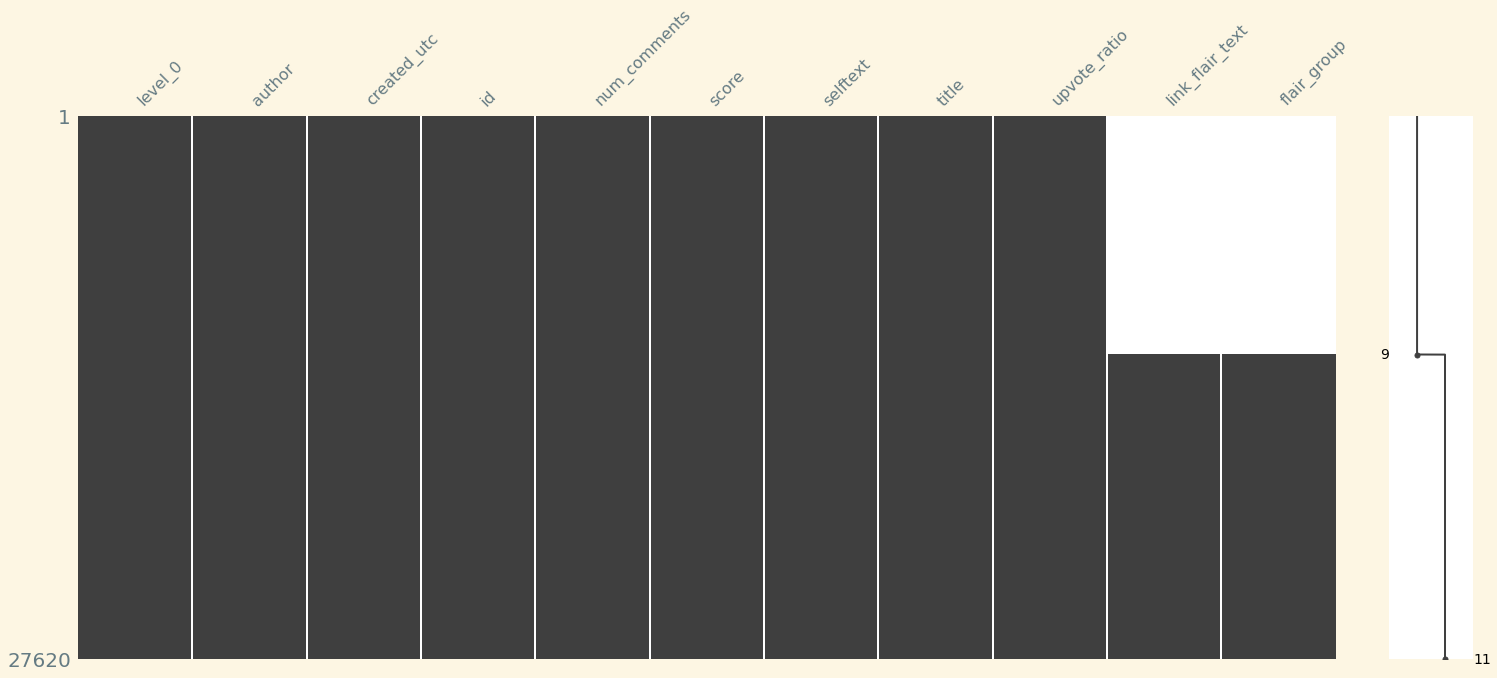

In [23]:
# we see missing values because r/SuicideWatch does not use the flair system
msno.matrix(df_combine)

In [24]:
# As r/SuicideWatch does not use the flair system we would fill NaN with 'None'
df_combine.fillna(value='None',inplace=True)

In [25]:
df_combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27620 entries, 0 to 27619
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   level_0          27620 non-null  bool   
 1   author           27620 non-null  object 
 2   created_utc      27620 non-null  int64  
 3   id               27620 non-null  object 
 4   num_comments     27620 non-null  int64  
 5   score            27620 non-null  int64  
 6   selftext         27620 non-null  object 
 7   title            27620 non-null  object 
 8   upvote_ratio     27620 non-null  float64
 9   link_flair_text  27620 non-null  object 
 10  flair_group      27620 non-null  object 
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 2.1+ MB


In [26]:
df_combine.shape

(27620, 11)

In [27]:
df_combine.rename(columns={'level_0':'is_suicidewatch'},inplace=True);

In [28]:
# Combining title and selftext
df_combine['alltext'] = df_combine['title'] + ' ' + df_combine['selftext']

Count duplicates across subreddits

In [29]:
# Count duplicates (reposts) across the two subreddits and indicate 'True' for reposts
reposts = df_combine['alltext'].value_counts().loc[lambda x : x>1]

In [30]:
# 'repost' = True if post count is more than 1
df_combine['repost'] = df_combine['alltext'].isin(reposts.index)

Count users who have posted in both subreddits

In [31]:
# Count of posts per subreddit per user
user_counts = df_combine[['is_suicidewatch','author']].value_counts().reset_index()

In [32]:
# List of users that posted in both subreddits
dual_user = user_counts['author'].value_counts().loc[lambda x : x>1]

In [33]:
# 'dual_user' = True if user has posted in both subreddits
df_combine['dual_user'] = df_combine['author'].isin(dual_user.index)

Data Cleaning

In [34]:
def text_cleaner(text):
    """This function takes in text, and removes any special 
    characters (e.g. '\n, non-alphanumeric, etc) found within it.
    After removal, it returns the cleaned text."""
    
    # removal of links from text
    # ref: https://code.tutsplus.com/tutorials/8-regular-expressions-you-should-know--net-6149
    text = re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '', text)
    
    # expand contractions
    text = contractions.fix(text)
    
    # convert emoji to text
    text = emoji.demojize(text)
    
    # remove any html artefacts
    text = BeautifulSoup(text).get_text()
    
    # removal of new line (\n) characted from text
    text = re.sub(r'\n',' ', text).lower()
    
    # removal of non-alphanumeric characters except hypens and apostrophes
    text = re.sub(r"[^A-Za-z0-9\-\s']", '', text)
    
    # removing any extra white spaces
    text = re.sub('\s+', ' ', text).strip()
    
    # returning cleaned text
    return text

In [35]:
# Cleaning text
df_combine['clean_alltext'] = df_combine['alltext'].apply(lambda x: text_cleaner(x))

In [36]:
# Calculate word count of title and selftext
tokenizer = RegexpTokenizer('\s+', gaps=True)

def tokenizer_func(text):
    return len(tokenizer.tokenize(text))

df_combine['word_count'] = df_combine['alltext'].apply(lambda x: tokenizer_func(x))

In [37]:
df_combine.shape

(27620, 16)

In [38]:
df_combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27620 entries, 0 to 27619
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   is_suicidewatch  27620 non-null  bool   
 1   author           27620 non-null  object 
 2   created_utc      27620 non-null  int64  
 3   id               27620 non-null  object 
 4   num_comments     27620 non-null  int64  
 5   score            27620 non-null  int64  
 6   selftext         27620 non-null  object 
 7   title            27620 non-null  object 
 8   upvote_ratio     27620 non-null  float64
 9   link_flair_text  27620 non-null  object 
 10  flair_group      27620 non-null  object 
 11  alltext          27620 non-null  object 
 12  repost           27620 non-null  bool   
 13  dual_user        27620 non-null  bool   
 14  clean_alltext    27620 non-null  object 
 15  word_count       27620 non-null  int64  
dtypes: bool(3), float64(1), int64(4), object(8)
memory usage: 

In [40]:
# Drop columns not needed anymore before exporting
df_combine_export = df_combine.drop(columns=['id','created_utc','selftext','title'], errors='ignore')

#### Export to CSV

In [41]:
# Save processed data to CSV
df_combine_export.to_csv('../Data/data_processed10.csv')